# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Data Cleaning

In [2]:
df = pd.read_csv('student_data.csv')

In [3]:
df['default payment next month'].value_counts()

0    18691
1     5308
Name: default payment next month, dtype: int64

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,2873,350000,1,1,2,37,-2,-2,-2,-2,...,466,466,316,316,316,466,466,316,316,0
1,3598,50000,2,2,1,37,2,2,2,0,...,13026,13268,13497,5500,0,580,600,600,600,0
2,27623,50000,2,1,2,23,-1,-1,-1,-1,...,4800,9810,660,2548,2321,4800,9810,660,2980,0
3,6874,20000,1,3,1,56,0,0,0,0,...,13784,13420,13686,1508,1216,1116,0,490,658,0
4,6444,110000,2,2,2,32,0,0,0,0,...,108829,110557,106082,5400,5400,4100,4100,4100,4200,0


In [5]:
df.rename(str.lower,inplace=True,axis='columns')

In [6]:
df.head(1)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default payment next month
0,2873,350000,1,1,2,37,-2,-2,-2,-2,...,466,466,316,316,316,466,466,316,316,0


In [6]:
df.rename(columns= {'pay_0':'pay_1','default payment next month':'default_pmt'},inplace=True)

In [7]:
df.loc[df['education']==0,'education']=4

In [8]:
df.loc[df['education']==5,'education']=4

In [9]:
df.loc[df['education']==6,'education']=4

In [10]:
df['education'].value_counts()

2    11188
1     8442
3     3994
4      375
Name: education, dtype: int64

In [11]:
fil = (df.pay_1 == -2) | (df.pay_1 == -1) | (df.pay_1 == 0)
df.loc[fil, 'pay_1'] = 0
fil = (df.pay_2 == -2) | (df.pay_2 == -1) | (df.pay_2 == 0)
df.loc[fil, 'pay_2'] = 0
fil = (df.pay_3 == -2) | (df.pay_3 == -1) | (df.pay_3 == 0)
df.loc[fil, 'pay_3'] = 0
fil = (df.pay_4 == -2) | (df.pay_4 == -1) | (df.pay_4 == 0)
df.loc[fil, 'pay_4'] = 0
fil = (df.pay_5 == -2) | (df.pay_5 == -1) | (df.pay_5 == 0)
df.loc[fil, 'pay_5'] = 0
fil = (df.pay_6 == -2) | (df.pay_6 == -1) | (df.pay_6 == 0)
df.loc[fil, 'pay_6'] = 0


## 2. EDA

In [12]:
df.columns

Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1',
       'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default_pmt'],
      dtype='object')

In [14]:
df.corr()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_pmt
id,1.000000,0.026323,0.019302,0.037888,-0.030753,0.017880,-0.021453,-0.007845,-0.019344,0.015891,...,0.041000,0.016271,0.016095,0.011810,0.009192,0.043608,0.008645,0.000182,0.003328,-0.012796
limit_bal,0.026323,1.000000,0.021791,-0.234748,-0.111852,0.138653,-0.167259,-0.196503,-0.193840,-0.182349,...,0.298083,0.298799,0.292456,0.191768,0.173765,0.208623,0.201759,0.216456,0.218044,-0.152838
sex,0.019302,0.021791,1.000000,0.012002,-0.028780,-0.092778,-0.033845,-0.045320,-0.042981,-0.040521,...,-0.021637,-0.016335,-0.015444,0.003678,0.001577,-0.010808,-0.002169,0.002347,0.001924,-0.039809
education,0.037888,-0.234748,0.012002,1.000000,-0.145484,0.185359,0.058113,0.065060,0.052267,0.048478,...,-0.012214,-0.017668,-0.018554,-0.041902,-0.035265,-0.044963,-0.038539,-0.046189,-0.040207,0.035234
marriage,-0.030753,-0.111852,-0.028780,-0.145484,1.000000,-0.409162,-0.013896,-0.013163,0.000630,-0.002955,...,-0.023084,-0.025111,-0.019539,-0.004430,-0.004399,-0.003262,-0.013261,0.001633,-0.004954,-0.021428
age,0.017880,0.138653,-0.092778,0.185359,-0.409162,1.000000,-0.000889,-0.006784,-0.012185,-0.008252,...,0.050574,0.046845,0.044077,0.022907,0.018468,0.028111,0.020261,0.017127,0.018235,0.012072
pay_1,-0.021453,-0.167259,-0.033845,0.058113,-0.013896,-0.000889,1.000000,0.697453,0.517315,0.463130,...,0.022168,0.030678,0.029489,-0.075795,-0.056173,-0.058724,-0.062367,-0.053431,-0.046045,0.395281
pay_2,-0.007845,-0.196503,-0.045320,0.065060,-0.013163,-0.006784,0.697453,1.000000,0.663637,0.513721,...,0.029647,0.037251,0.039019,-0.096551,-0.053936,-0.059153,-0.055520,-0.048954,-0.039979,0.325601
pay_3,-0.019344,-0.193840,-0.042981,0.052267,0.000630,-0.012185,0.517315,0.663637,1.000000,0.675188,...,0.015832,0.025375,0.029550,-0.038380,-0.070531,-0.056140,-0.054127,-0.048000,-0.046248,0.288786
pay_4,0.015891,-0.182349,-0.040521,0.048478,-0.002955,-0.008252,0.463130,0.513721,0.675188,1.000000,...,0.009938,0.022736,0.029739,-0.052593,-0.036840,-0.072760,-0.054098,-0.051161,-0.049185,0.270149


NameError: name 'df' is not defined

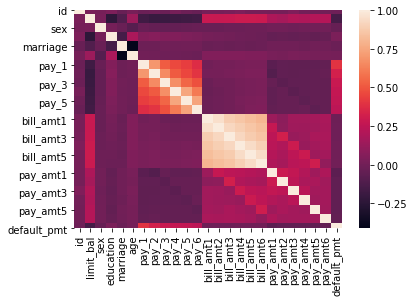

In [13]:
sns.heatmap(df.corr())


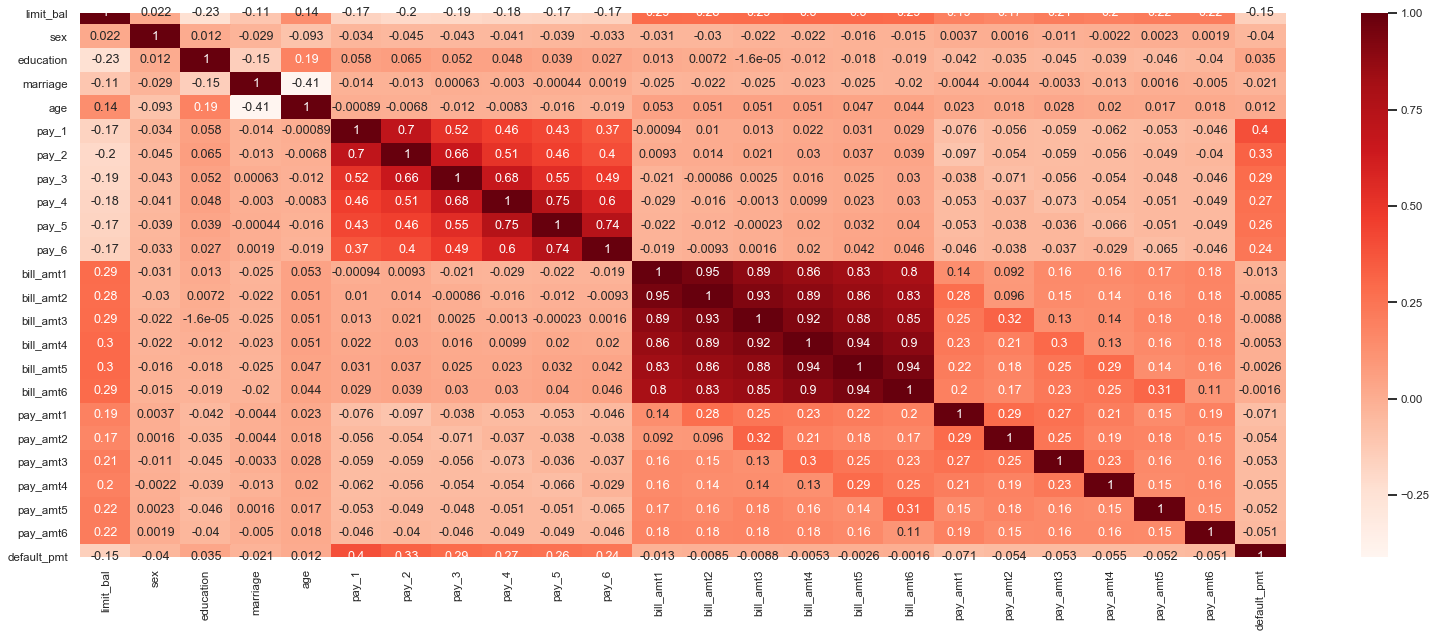

In [14]:
sns.set(rc={'figure.figsize':(27,10)})
sns.set_context("talk", font_scale=0.7)
    
sns.heatmap(df.iloc[:,1:].corr(), cmap='Reds', annot=True);

## 3. Feature Engineering

## 4. Feature Selection

In [16]:
dummies_sex=pd.get_dummies(df['sex'],prefix='sex',drop_first=True)
dummies_education=pd.get_dummies(df['education'],prefix='edu',drop_first=True)
dummies_marriage=pd.get_dummies(df['marriage'],prefix='marry',drop_first=True)

In [17]:
df1= df.drop(['sex','marriage','education'], axis=1)

In [18]:
df2 = pd.concat([df1,dummies_sex, dummies_education, dummies_marriage], axis=1)
df2.head()

,id,limit_bal,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt5,pay_amt6,default_pmt,sex_2,edu_2,edu_3,edu_4,marry_1,marry_2,marry_3
0,2873,350000,37,0,0,0,0,0,0,316,...,316,316,0,0,0,0,0,0,1,0
1,3598,50000,37,2,2,2,0,0,0,40994,...,600,600,0,1,1,0,0,1,0,0
2,27623,50000,23,0,0,0,0,0,0,3430,...,660,2980,0,1,0,0,0,0,1,0
3,6874,20000,56,0,0,0,0,2,0,10847,...,490,658,0,0,0,1,0,1,0,0
4,6444,110000,32,0,0,0,0,0,0,108159,...,4100,4200,0,1,1,0,0,0,1,0


## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [20]:
X=df2.drop(['default_pmt','id'],axis=1)
y=df2['default_pmt']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [23]:
k_scores=[]
#set up a loop to fit the model using a different values of K
k_range = list(range(1, 15))
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors= k)
    #fit the model and get the score on a evaluation metric
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
#     acc = metrics.accuracy_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    k_scores.append(f1_score)
    # Print out the scores to see which one is best.
print("for neightbours = ",k,"Score =",k_scores)

for neightbours =  14 Score = [0.3716608594657375, 0.3120488617434759, 0.42445724412937524, 0.3628462791960891, 0.42125237191650855, 0.38038793103448276, 0.4270884824518042, 0.39546191247974066, 0.43064596895343016, 0.3982542280414621, 0.4385245901639344, 0.4023926046764546, 0.43491735537190085, 0.3925845147219193]


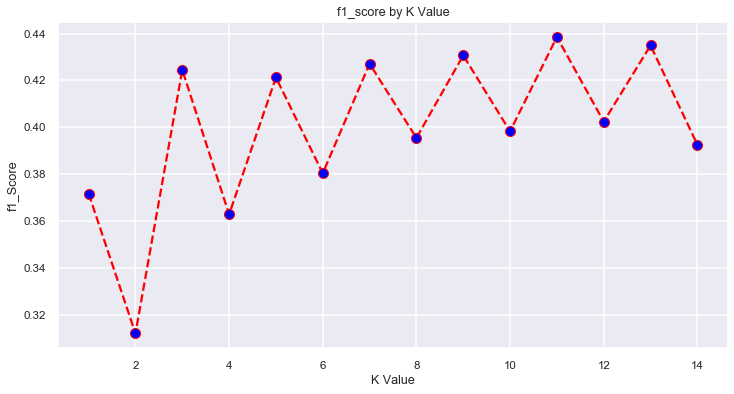

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(k_range, k_scores, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('f1_score by K Value')
plt.xlabel('K Value')
plt.ylabel('f1_Score')
plt.show()

LOGISTIC REGRESSION


In [56]:
X_train

,limit_bal,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,...,pay_amt4,pay_amt5,pay_amt6,sex_2,edu_2,edu_3,edu_4,marry_1,marry_2,marry_3
1377,80000,37,0,0,0,0,0,0,1480,3832,...,0,2791,0,1,1,0,0,1,0,0
8439,50000,23,0,0,0,0,0,0,496,454,...,1000,1000,1000,1,0,0,0,0,1,0
23375,50000,41,0,0,2,0,0,0,2602,12150,...,79,232,110,0,0,1,0,1,0,0
5719,150000,30,0,0,0,0,0,0,8821,5943,...,4896,1477,4303,0,1,0,0,0,1,0
7833,340000,29,0,0,0,0,0,0,11806,13535,...,400,5857,6500,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,130000,28,0,0,0,0,0,0,3964,600,...,0,427,1747,0,0,1,0,0,1,0
17289,300000,50,0,0,0,0,0,0,8924,3131,...,5000,9000,5000,1,1,0,0,1,0,0
5192,50000,25,0,0,2,0,0,0,20123,19184,...,452,451,370,1,1,0,0,0,1,0
12172,150000,24,0,0,0,0,0,0,1495,2053,...,0,0,0,1,0,0,0,0,1,0


In [57]:
# concatenate our training data back together
training  = pd.concat([X_train, y_train], axis=1)

In [58]:
training

,limit_bal,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,...,pay_amt5,pay_amt6,sex_2,edu_2,edu_3,edu_4,marry_1,marry_2,marry_3,default_pmt
1377,80000,37,0,0,0,0,0,0,1480,3832,...,2791,0,1,1,0,0,1,0,0,0
8439,50000,23,0,0,0,0,0,0,496,454,...,1000,1000,1,0,0,0,0,1,0,0
23375,50000,41,0,0,2,0,0,0,2602,12150,...,232,110,0,0,1,0,1,0,0,1
5719,150000,30,0,0,0,0,0,0,8821,5943,...,1477,4303,0,1,0,0,0,1,0,0
7833,340000,29,0,0,0,0,0,0,11806,13535,...,5857,6500,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,130000,28,0,0,0,0,0,0,3964,600,...,427,1747,0,0,1,0,0,1,0,0
17289,300000,50,0,0,0,0,0,0,8924,3131,...,9000,5000,1,1,0,0,1,0,0,0
5192,50000,25,0,0,2,0,0,0,20123,19184,...,451,370,1,1,0,0,0,1,0,0
12172,150000,24,0,0,0,0,0,0,1495,2053,...,0,0,1,0,0,0,0,1,0,0


In [59]:
# separate minority and majority classes
no_default = training[training.default_pmt==0]
yes_default = training[training.default_pmt==1]

In [61]:
# Get a class count to understand the class imbalance.
print('No_default count: '+ str(len(no_default)))
print('Yes_default count: '+ str(len(yes_default)))

No_default count: 13952
Yes_default count: 4047


In [62]:
from sklearn.utils import resample


In [63]:
# upsample minority
survived_upsampled = resample(yes_default,
                          replace=True, # sample with replacement
                          n_samples=len(no_default), # match number in majority class
                          random_state=23) # reproducible results

In [64]:
# combine majority and upsampled minority
upsampled = pd.concat([no_default, survived_upsampled])

# check new class counts
upsampled.default_pmt.value_counts()

1    13952
0    13952
Name: default_pmt, dtype: int64

In [69]:
from sklearn.linear_model import LogisticRegression


In [128]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.default_pmt
X_train = upsampled.drop('default_pmt', axis=1)


# upsampled_dt = DecisionTreeClassifier(max_depth=5)
upsampled_lr = LogisticRegression(solver='liblinear')


# upsampled_dt.fit(X_train, y_train)
upsampled_lr.fit(X_train, y_train)


# upsampled_pred = upsampled_dt.predict(X_test)
upsampled_pred = upsampled_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', metrics.accuracy_score(y_test, upsampled_pred))


# checking accuracy
print('Test F1 score: ', metrics.f1_score(y_test, upsampled_pred))



SyntaxError: invalid syntax (<ipython-input-128-7905fbb69a9d>, line 7)

DECISION TREE

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
X=df2.drop(['default_pmt','id'],axis=1)
y=df2['default_pmt']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [28]:
y_train

1377     0
8439     0
23375    1
5719     0
7833     0
        ..
10955    0
17289    0
5192     0
12172    0
235      0
Name: default_pmt, Length: 17999, dtype: int64

In [29]:
parameters={'criterion': ['gini','entropy'],
            'min_samples_leaf' : range(5,100,15),
            'max_depth': range(2,20,1)}

In [30]:
from sklearn.model_selection import GridSearchCV
#create our estimaor
clf_tree=DecisionTreeClassifier(random_state=1)
#create the instance of GridSearchCV
grid_tree=GridSearchCV(clf_tree, parameters, cv=5, scoring='f1')
#fit the Gridsearch to our data
grid_tree.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 20),
                         'mi

In [31]:
# examine the best model
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)
# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)
# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)

0.4766313211398869
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 95}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=95, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')


In [32]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion= 'gini',max_depth= 3, min_samples_leaf=95)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
#predict the training set
y_pred_train = clf.predict(X_train)
#Predict the response for test dataset
y_pred_test = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Training F1 Score:",metrics.f1_score(y_train, y_pred_train))
print("Testing F1 Score:",metrics.f1_score(y_test, y_pred_test))


Training F1 Score: 0.4728444802578566
Testing F1 Score: 0.4845099035043169


XGBOOST

In [37]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, KFold
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [78]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic',
#                            colsample_bytree = 0.3,
#                            subsample = 0.5,
                           learning_rate = 0.7,
                           max_depth = 8,
                           alpha = 0.8,
#                            scale_pos_weight= df2['default_pmt'].mean(),
                           n_estimators = 800)

In [79]:
xg_clf.fit(X_train,y_train)    

XGBClassifier(alpha=0.8, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.7, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [80]:

preds = xg_clf.predict(X_test)
test_f1 = metrics.f1_score(y_test, preds)
test_acc = metrics.accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.792333
F1: 0.438739


In [71]:
param_dist = {'n_estimators': [800],
              'learning_rate': [0.7,0.8,0.9,1],
              'max_depth': [6,7,8],
              'alpha': [0.8,1]}

In [72]:
gsearch1 = GridSearchCV(
    estimator = xg_clf,
    param_grid = param_dist, 
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    iid=False, 
    cv=5)

In [73]:
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 51.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(alpha=0.8, base_score=0.5,
                                     booster='gbtree', colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.8,
                                     max_delta_step=0, max_depth=8,
                                     min_child_weight=1, missing=None,
                                     n_estimators=800, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=-1,
             param_grid={'alpha': [0.8, 1], 'learning_rate': [0.7, 0.8, 0.9, 1],
                         'max_depth': [6,

In [74]:
gsearch1.cv_results_

{'mean_fit_time': array([ 94.99453082, 101.04826527, 109.42666864,  88.71580901,
         99.80449128, 111.48477635,  92.31708074, 102.63651347,
        110.78988748,  92.69295673, 101.43867884, 111.08004236,
         92.1301415 , 103.54549441, 113.54919672,  93.59662738,
        108.21594534, 111.98108039,  92.28002853, 102.04463949,
        110.04334645,  91.45856977, 101.30717635, 104.98017735]),
 'std_fit_time': array([2.21824091, 0.60532809, 0.1117532 , 0.02836725, 0.86448217,
        0.93248368, 0.19136707, 0.25330463, 0.63235386, 0.54500882,
        0.24710584, 0.99261235, 0.32431583, 0.42994533, 0.16646463,
        1.7339186 , 2.01240954, 0.34608046, 0.2161076 , 0.23767194,
        0.40397127, 0.15001071, 0.37921965, 5.82090491]),
 'mean_score_time': array([0.32974606, 0.4260437 , 0.46965399, 0.32711401, 0.45429749,
        0.54723506, 0.39264054, 0.50421691, 0.53768625, 0.50163198,
        0.49215059, 0.53281679, 0.36346016, 0.47184196, 0.56275692,
        0.38004231, 0.516798

In [75]:
gsearch1.best_params_

{'alpha': 0.8, 'learning_rate': 0.7, 'max_depth': 8, 'n_estimators': 800}

In [76]:
gsearch1.best_score_

0.9232029040384375

In [77]:
preds = gsearch1.best_estimator_.predict(X_test)


test_f1 = metrics.f1_score(y_test, preds)
test_acc = metrics.accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.792333
F1: 0.438739


Random Forest 

In [82]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


In [125]:
forest = RandomForestClassifier(criterion='gini',n_estimators=200, max_depth= 10, min_samples_leaf= 5, random_state= 23)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [126]:
# Training accuracy score
forest.score(X_train, y_train)

0.777702121559633

In [127]:
# Test accuracy score
forest.score(X_test, y_test)

y_test_predict= forest.predict(X_test)

metrics.f1_score(y_test,y_test_predict)

0.5292656970556935

In [86]:
parameters={'criterion': ['gini','entropy'],
            'min_samples_leaf' : range(5,100,15),
            'max_depth': range(2,11,1)}

In [87]:
grid_tree=GridSearchCV(forest, parameters, cv=5, scoring='f1')
#fit the Gridsearch to our data
grid_tree.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='warn

In [88]:
# examine the best model
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)
# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)
# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)

0.733992303796136
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


## 6. Model Evaluation

## 7. Final Model